# Disjunctive Programming
Let's compare two different approaches to disjunctive programming: Big-M and convex hull. 

## A simple problem
minimize $ x^\top Q x + q^\top x $

subject to:
$$
x \in R_1 \cup R_2
$$

where $R_i$ is a polyhedron specified by
$$
R_i \equiv \{ x\  |\  A_i x \leq b_i \}
$$

## Binary variables
We'll rewrite the above problem by introducing binary variables $z_i$:

minimize $ x^\top Q x + q^\top x $

over $x$, $z_i$

subject to:
$$
\begin{aligned}
z_1 = 1 \implies x \in R_1\\
z_2 = 1 \implies x \in R_2\\
z_i \in \{0, 1\}\\
\sum_i z_i = 1
\end{aligned}
$$


## Big-M
The big-M formulation lets us convert the implies operators into linear constraints:

$$
z_i = 1 \implies x \in R_i
$$

becomes

$$
A_i x + M z_i \leq b_i + M
$$

If M is sufficiently big, then when $z_i$ is $0$, the constraint becomes trivial, and when $z_i$ is $1$, the constraint becomes exactly $x \in R_1$. 


# Implementation
## Generating regions
We'll generate the regions as the convex hull of some random points:

In [1]:
using CHull

In [27]:
dim = 2
num_regions = 2
P = Array{Float64,2}[]
A = Array{Float64,2}[]
b = Array{Float64,2}[]
R = [0 1; -1 0]

for j in 1:num_regions
    push!(P, rand(4, dim) .+ [j 0])
    hull = chull(P[j])
    push!(A, Array(Float64, size(hull.vertices)[1], size(P[j])[2]))
    push!(b, Array(Float64, size(hull.vertices, 1), 1))
    for i in 1:size(hull.vertices, 1)
        v = P[j][hull.vertices[i,2], :] - P[j][hull.vertices[i,1], :]
        
        A[j][i,:] = (R * v.')
        A[j][i,:] = A[j][i,:] ./ norm(A[j][i,:])
        b[j][i,:] = (A[j][i,:] * P[j][hull.vertices[i,1],:].')
    end
end

In [28]:
using JuMP

In [29]:
bigM = Model()

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver set to Default

In [30]:
@defVar(bigM, x[1:dim])

2-element Array{Variable,1}:
 x[1]
 x[2]

In [31]:
@defVar(bigM, z[1:num_regions], Bin)

2-element Array{Variable,1}:
 z[1]
 z[2]

In [32]:
@addConstraint(bigM, sum(z) == 1)

z[1] + z[2] = 1

In [33]:
M = 100
for i in 1:num_regions
    @addConstraint(bigM, A[i] * x .+ M * z[i] .<= b[i] .+ M)
end


In [43]:
@setObjective(bigM, Min, sum((x - [2; 1.5]).^2))

:Min

In [44]:
bigM

Minimization problem with:
 * 7 linear constraints
 * 4 variables: 2 binary
Solver set to Default

In [45]:
status = solve(bigM)

Optimize a model with 7 rows, 4 columns and 20 nonzeros
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range    [2e-01, 1e+02]
  Objective range [3e+00, 4e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 6 rows, 3 columns, 18 nonzeros
Presolved model has 2 quadratic objective terms

Loaded MIP start with objective -5.4708

Variable types: 2 continuous, 1 integer (1 binary)

Root relaxation: objective -6.250000e+00, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -6.25000    0    1   -5.47080   -6.25000  14.2%     -    0s
*    0     0               0      -5.6517284   -5.65173  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.00 seconds
Thread count was 4 (of 8 available processors)

Optimal solution found (toleran

:Optimal

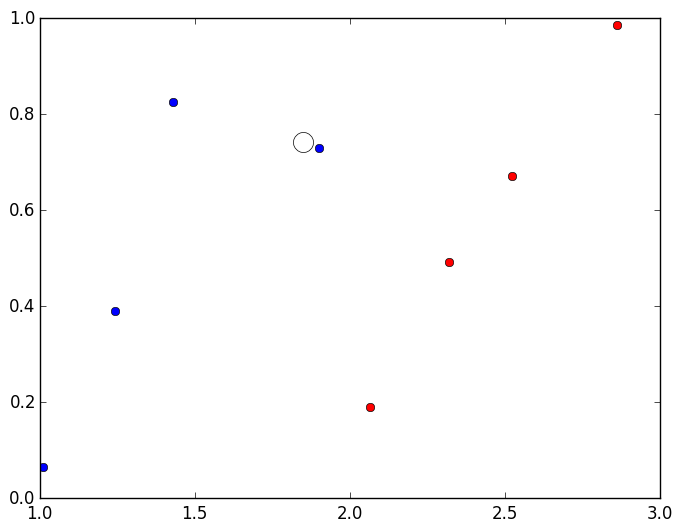

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11ae203d0>

In [48]:
using PyPlot
figure()
hold(1)
colors = ["b", "r", "g", "k"]
for j in 1:num_regions
    plot(P[j][:,1], P[j][:,2], "$(colors[j])o")
end
plot([getValue(x[1])], [getValue(x[2])], "go", markersize=15, markerfacecolor="none")